We need to clone the repo to download the datasets and utils

In [1]:
!git clone https://github.com/Ariel5/hand-gesture-recognition.git

Cloning into 'hand-gesture-recognition'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 47 (delta 24), reused 39 (delta 16), pack-reused 0
Receiving objects: 100% (47/47), 8.93 MiB | 10.82 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [2]:
%cd hand-gesture-recognition/

/Users/ariellubonja/My Drive (lubonjaariel@gmail.com)/Documents/Johns Hopkins University/Classes/Spring 2023/EN.601.661 Computer Vision/project/hand-gesture-recognition


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # graphing 


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
!ls

datasets
finger_gesture_detection_computer_vision_project.ipynb
log_files
model_files
utils


In [5]:
# Opening H5 file
import h5py # https://www.h5py.org

training_data = h5py.File("./datasets/Signs_Data_Training.h5", "r")
training_data

<HDF5 file "Signs_Data_Training.h5" (mode r)>

In [6]:
training_data.keys()

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>

In [7]:
import torch

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = 'cpu'

In [9]:
X_train = np.array(training_data['train_set_x'])
y_train = np.array(training_data['train_set_y'])

# train_data = torch.tensor(training_data['train_set_x']) # This is really slow
train_data = torch.tensor(X_train)
# train_labels = torch.tensor(training_data['train_set_y']) # This is really slow
train_labels = torch.tensor(y_train)
print("Train data shape: ", train_data.shape)

Train data shape:  torch.Size([1080, 64, 64, 3])


#### 1080 photos of 64x64 size, 3 colors

### Transpose data into the format Torch wants - (n_channels, width, height)
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html

In [10]:
# # https://numpy.org/doc/stable/reference/generated/numpy.transpose.html

# train_data = train_data.view((100, 3, 64, 64))


# train_data.shape

In [11]:
# Taken from Yann's paper
class LeNet5(torch.nn.Module):
    def __init__(self, input_height, input_width, n_classes):
        super().__init__()

        # C1. Put padding bcs MNIST had 32x32 data. We have 28x28
        self.C1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, padding=2)
        #feature extraction of 5x5 kernels
    
        # S2
        self.S2 = torch.nn.AvgPool2d(kernel_size=2)
        #reduce dimensions of feature maps while preserving info
        
        
        # C3
        self.C3 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        #feature extraction of 5x5 kernels

        # S4
        self.S4 = torch.nn.AvgPool2d(kernel_size=4) # Edited this due to our data being 64x64
        #reduce dimensions of feature maps while preserving info


        
        
        # C5
        self.C5 = torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=7) # Edited this due to our data being 64x64
        #feature extraction of 5x5 kernels

        # F6
        self.F6 = torch.nn.Linear(in_features= 120, out_features=84)
        # self.layer4 = torch.nn.Conv2d(in_channels=64, out_channels=16, kernel_size=1)
        #neuron layer

        # F7
        self.F7 = torch.nn.Linear(in_features= 84, out_features=n_classes)
        #neuron layer
        
    
    
    def forward(self, x):
        
        ### forward pass module
        # x = torch.unsqueeze(x, 1)

        ### feed forward function
#         print("x.shape: ", x.shape)
        
        # PyTorch expects (Batch_size, channel_nr, width, height)
        
        l1out = self.C1(x)
        l1out = torch.nn.Tanh()(l1out)
        
        # print("l1out.shape: After C1 and TanH", l1out.shape)

        # AvgPooling
        l2out = self.S2(l1out)
        
        # print("l2out.shape: after AvgPooling ", l2out.shape)

        l3out = self.C3(l2out)
        l3out = torch.nn.Tanh()(l3out)
        
        # print("l3out.shape: After C3 and TanH", l3out.shape)

        # AvgPooling
        l4out = self.S4(l3out)
        
        # print("l4out.shape, After Avg Pooling: ", l4out.shape)

        l5out = self.C5(l4out)
        l5out = torch.nn.Tanh()(l5out)
        l5out = np.squeeze(l5out)
        # print("l5out.shape: after C5 and Tanh: ", l5out.shape)
        
        l5out = torch.nn.Dropout()(l5out)
        
        l6out = self.F6(l5out) # squeeze bcs (120,1) vector to (120,) - a numpy broadcast thing
        l6out = torch.nn.Tanh()(l6out)
        # print("l6out.shape: after F6 and squeeze ", l6out.shape)
        
        l7out = self.F7(l6out)
        # print("l7out.shape: After F7 ", l7out.shape)

        return l7out
    
    
#feature extraction C1
#activation with Tanh
#Pooling (reduce dimensions) S2

#feature extraction C3
#activation with Tanh
#pooling (reduce dimensions) S4

#feature extraction C5
#activatiton with Tanh

#Linear squeeze 
#activation with Tanh

#Linear squeeze to outputs

## Split Train into Train and Dev. Test set is in another HDF5 file

In [12]:
# Create Cross-Validation/Dev set
from sklearn.model_selection import train_test_split

X_train, X_dev, y_train, y_dev = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

In [13]:
print("X_train.shape: ", X_train.shape)
print("y_train.shape: ", y_train.shape)

X_train.shape:  torch.Size([864, 64, 64, 3])
y_train.shape:  torch.Size([864])


In [14]:
MODE = "train"

In [15]:
# https://towardsdatascience.com/installing-pytorch-on-apple-m1-chip-with-gpu-acceleration-3351dc44d67c

# this ensures that the current MacOS version is at least 12.3+
#print(torch.backends.mps.is_available())

# this ensures that the current current PyTorch installation was built with MPS activated.
#print(torch.backends.mps.is_built())

In [16]:
# torch.device("mps") # Disable this if not on apple silicon!

### Move to GPU if available

In [17]:
TRAIN_IMAGES = X_train.to(device)
TRAIN_LABELS = y_train.to(device)
DEV_IMAGES = X_dev.to(device)
DEV_LABELS = y_dev.to(device)

In [18]:
TRAIN_IMAGES.device

device(type='cpu')

In [19]:
TRAIN_IMAGES.shape

torch.Size([864, 64, 64, 3])

In [20]:
TRAIN_IMAGES = TRAIN_IMAGES.view(len(TRAIN_IMAGES), 3, 64, 64)
DEV_IMAGES = DEV_IMAGES.view(len(DEV_IMAGES), 3, 64, 64)

In [21]:
b = TRAIN_IMAGES.view(len(TRAIN_IMAGES), 64,64, 3)[0,:,:,:]
b.shape

torch.Size([64, 64, 3])

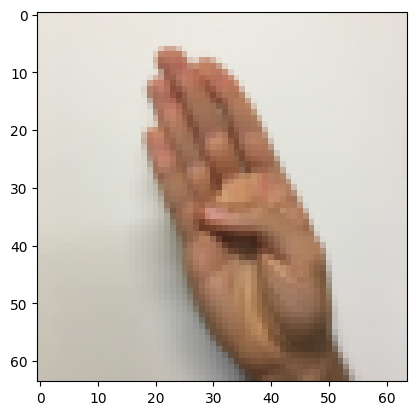

In [22]:
plt.imshow(b.cpu())

In [23]:
a = DEV_IMAGES.view(len(DEV_IMAGES), 64,64,3)[0,:,:,:].cpu()
a.shape

torch.Size([64, 64, 3])

In [24]:
DEV_IMAGES.dtype

torch.uint8

## Train model

In [29]:
import datetime
from utils.accuracies import dev_acc_and_loss, approx_train_acc_and_loss
import torch.nn.functional as F

# Modified From Ariel's EN.601.675 HW3
        
LOG_DIR = "."
MODEL_SAVE_DIR = "."
LEARNING_RATE = 0.0004 #arguments.get('lr')
BATCH_SIZE = 100 # 250 #arguments.get('bs')
EPOCHS = 2000 # arguments.get('epochs')
DATE_PREFIX = datetime.datetime.now().strftime('%Y%m%d%H%M')

### format dataset to the appropriate shape/dimensions necessary to be input into the model


n_train_imgs = TRAIN_IMAGES.shape[0]
HEIGHT = TRAIN_IMAGES.shape[1]
WIDTH = TRAIN_IMAGES.shape[2]
#  this will not be correct if not all classes are present in training
#   But if classes are entirely missing from training, we cannot possibly hope to do well on them
N_CLASSES = len(torch.unique(TRAIN_LABELS))
# raise NotImplementedError

### Normalize 
train_imgs = (TRAIN_IMAGES - torch.mean(torch.Tensor.float(TRAIN_IMAGES)))/ torch.std(torch.Tensor.float(TRAIN_IMAGES))
dev_imgs = (DEV_IMAGES - torch.mean(torch.Tensor.float(DEV_IMAGES)))/ torch.std(torch.Tensor.float(DEV_IMAGES))

### change depending on your model's instantiation

model = LeNet5(input_height = HEIGHT, input_width= WIDTH,
                  n_classes=N_CLASSES)
if device.type != 'cpu':
    model.cuda()


### (OPTIONAL) : you can change the choice of optimizer here if you wish.
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

train_acc_col = []
train_loss_col = []
dev_acc_col = []
dev_loss_col = []
steps_col = []
for step in range(EPOCHS):
    i = np.random.choice(train_imgs.shape[0], size=BATCH_SIZE, replace=False)
    x = train_imgs[i]#).astype(np.float32))
    y = TRAIN_LABELS[i]#.astype(int)))

    # x = x.unsqueeze(0)

    # Forward pass: Get logits for x
    logits = model(x)
    # Compute loss
    loss = F.cross_entropy(logits, y)
    # Zero gradients, perform a backward pass, and update the weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_acc, train_loss = approx_train_acc_and_loss(model, train_imgs, TRAIN_LABELS)
    # train_acc, train_loss = dev_acc_and_loss(model, train_imgs, TRAIN_LABELS)
    dev_acc, dev_loss = dev_acc_and_loss(model, dev_imgs, DEV_LABELS)
    train_acc_col.append(train_acc)
    train_loss_col.append(train_loss)
    dev_acc_col.append(dev_acc)
    dev_loss_col.append(dev_loss)
    steps_col.append(step)
    # log model performance every 100 epochs
    if step % 100 == 0:
      
        step_metrics = {
            'step': step, 
            'train_loss': loss.item(), 
            'train_acc': train_acc,
            'dev_loss': dev_loss,
            'dev_acc': dev_acc
        }

        print(f"On step {step}:\tTrain loss {train_loss}\t|\tTrain acc is {train_acc}|\tDev acc is {dev_acc}")
        # logger.writerow(step_metrics)
# LOGFILE.close()

# Save model
model_savepath = os.path.join(MODEL_SAVE_DIR,f"{DATE_PREFIX}_bestmodel.pt")


print("Training completed, saving model at {model_savepath}")
torch.save(model, model_savepath)



On step 0:	Train loss 1.7842493057250977	|	Train acc is 0.23000000417232513|	Dev acc is 0.21759259700775146
On step 100:	Train loss 0.9968055486679077	|	Train acc is 0.6299999952316284|	Dev acc is 0.6018518805503845
On step 200:	Train loss 0.7808311581611633	|	Train acc is 0.6600000262260437|	Dev acc is 0.6666666865348816
On step 300:	Train loss 0.743337869644165	|	Train acc is 0.699999988079071|	Dev acc is 0.6898148059844971
On step 400:	Train loss 0.40573978424072266	|	Train acc is 0.8600000143051147|	Dev acc is 0.7453703880310059
On step 500:	Train loss 0.3650921881198883	|	Train acc is 0.8999999761581421|	Dev acc is 0.7083333134651184
On step 600:	Train loss 0.38306835293769836	|	Train acc is 0.8299999833106995|	Dev acc is 0.7361111044883728
On step 700:	Train loss 0.31244200468063354	|	Train acc is 0.9200000166893005|	Dev acc is 0.7361111044883728
On step 800:	Train loss 0.34506553411483765	|	Train acc is 0.8799999952316284|	Dev acc is 0.7314814925193787
On step 900:	Train loss 0.

In [30]:
next(model.parameters()).device # Where is model on?

device(type='cpu')

## Plot loss curves

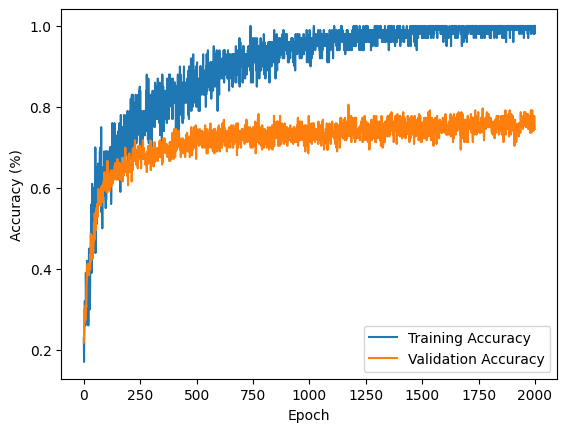

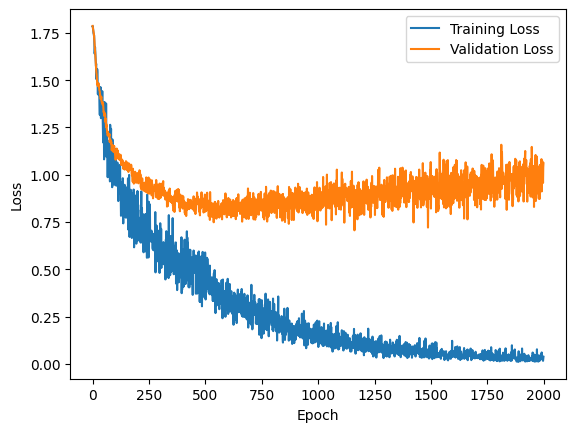

Final Stats:	Train loss 0.037118881940841675	|	Validation Loss 1.0606789588928223	|	Train acc is 1.0 	|	Dev acc is 0.7453703880310059


In [31]:
fig1 = plt.figure()
plt.plot(steps_col, [acc.cpu() for acc in train_acc_col], label = "Training Accuracy")
plt.plot(steps_col, [acc.cpu() for acc in dev_acc_col], label = "Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()


fig2 = plt.figure()
plt.plot(steps_col, train_loss_col, label = "Training Loss")
plt.plot(steps_col, dev_loss_col, label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

print(f"Final Stats:\tTrain loss {train_loss_col[1999]}\t|\tValidation Loss {dev_loss_col[1999]}\t|\tTrain acc is {train_acc_col[1999]} \t|\tDev acc is {dev_acc_col[1999]}")
    

## Let's see performance on test set

In [37]:
test_data = h5py.File("./datasets/Signs_Data_Testing.h5", "r")
TEST_IMAGES = torch.tensor(np.array(test_data["test_set_x"])).to(device)
test_labels = torch.tensor(np.array(test_data["test_set_y"])).to(device) # Do not train on these!!

In [38]:
# Transpose into correct shape for PyTorch

TEST_IMAGES = TEST_IMAGES.view((len(TEST_IMAGES), 3, 64, 64))

In [39]:
TEST_IMAGES.shape

torch.Size([120, 3, 64, 64])

In [40]:
MODE = "test"
model.eval()

LeNet5(
  (C1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (S2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (C3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (S4): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (C5): Conv2d(16, 120, kernel_size=(7, 7), stride=(1, 1))
  (F6): Linear(in_features=120, out_features=84, bias=True)
  (F7): Linear(in_features=84, out_features=6, bias=True)
)

In [45]:
# model = torch.load(WEIGHTS_FILE) # Load model parameters from file to avoid retraining

### normalization
test_case = (TEST_IMAGES - torch.mean(torch.Tensor.float(TRAIN_IMAGES)))/ torch.std(torch.Tensor.float(TRAIN_IMAGES))

logits = model(test_case)#.unsqueeze(0))
logits = logits.reshape(-1, 6)
predictions = torch.max(logits, 1)[1]

predictions[:15]

tensor([0, 2, 0, 5, 2, 0, 5, 1, 5, 2, 5, 1, 3, 1, 1])

In [46]:
len(predictions)

120

In [47]:
from utils.accuracies import accuracy

print("Test accuracy: ", accuracy(predictions.cpu(), test_labels.cpu()))

Test accuracy:  tensor(0.7250)


In [ ]:
import albumentations as A
transform = A.Compose([
    A.affinerotate(p = 0.33)
    #A.HorizontalFlip(p = 0.5),
    #A.ColorJitter(brightness= 0, contrast=(1, 1.5), saturation=(0.5,1), hue=0, p=1)
])
print("done")

In [ ]:
import cv2
X_dev2 = []
for num in range(3):
    for pos, imageSet in enumerate(X_dev):
        merged = cv2.merge([imageSet[2], imageSet[1], imageSet[0]])
        image = cv2.cvtColor(merged, cv2.COLOR_BGR2RGB)
        image = transform(image=image)['image']
        X_dev2.append(image)
print('done')

In [ ]:
for pos, image in enumerate(X_dev2):
    plt.figure()
    plt.title(pos)
    plt.imshow(image)
   

In [ ]:
for pos, imageSet in enumerate(X_dev):
    if pos == 87:
        merged = cv2.merge([imageSet[2], imageSet[1], imageSet[0]])
        image = cv2.cvtColor(merged, cv2.COLOR_BGR2RGB)
        plt.figure()
        plt.title(pos)
        plt.imshow(image)

In [ ]:
print(y_dev[87])